In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
from timeit import default_timer as timer

from torchphysics.problem import Variable
from torchphysics.setting import Setting
from torchphysics.problem.domain import (Rectangle,
                                           Interval,
                                           Circle)
from torchphysics.problem.condition import (DirichletCondition,
                                              DiffEqCondition,
                                              DataCondition)
from torchphysics.models.fcn import SimpleFCN
from torchphysics import PINNModule
from torchphysics.utils import laplacian, jac, convective
from torchphysics.utils.fdm import FDM, create_validation_data
from torchphysics.utils.plot import Plotter
from torchphysics.utils.evaluation import (get_min_max_inside,
                                             get_min_max_boundary)
from torchphysics.setting import Setting

os.environ["CUDA_VISIBLE_DEVICES"] = "2" # select GPUs to use

#pl.seed_everything(43) # set a global seed
torch.cuda.is_available()

True

In [2]:
w, h = 2, 1
t0, tend = 0, 20
Re = 50

u = 'u'

In [3]:
from torchphysics.problem.domain.domain_operations import Cut

R = Rectangle(corner_dl=[0, 0], corner_dr=[w, 0], corner_tl=[0, h])
C = Circle([w/3,0], h/3)

x = Variable(name='x',
             order=2,
             domain=Cut(R,C),
             train_conditions={},
             val_conditions={})
t = Variable(name='t',
             order=1,
             domain=Interval(low_bound=0,
                             up_bound=tend),
             train_conditions={},
             val_conditions={})

In [4]:
norm = torch.nn.MSELoss()
# at start: erverything 0
def t_dirichlet_fun(**input):
    return np.zeros_like(input['x'])

t.add_train_condition(DirichletCondition(dirichlet_fun=t_dirichlet_fun,
                                         solution_name=u,
                                         whole_batch=True,
                                         name='dirichlet',
                                         norm=norm,
                                         dataset_size=500,
                                         boundary_sampling_strategy='lower_bound_only',
                                         data_plot_variables=('x','t')))
# at boundary: flow dependent on time (left into the domain, right out of the domain)
# y component always zero
# at points where this function returns None, no boundary condition will be applied
def x_dirichlet_fun(x, t):
    out = np.zeros(2)
    if np.isclose(x[0], 0):
        out[0] = 5*x[1]*(h-x[1])*(1-np.exp(-t))
        return out
    if not np.isclose(x[0], w):
        return out

x.add_train_condition(DirichletCondition(dirichlet_fun=x_dirichlet_fun,
                                         solution_name=u,
                                         whole_batch=False, # this enables us to use point-wise defined dirichlet_fun
                                         name='dirichlet',
                                         sampling_strategy='grid',
                                         boundary_sampling_strategy='grid',
                                         norm=norm,
                                         weight=1.0,
                                         dataset_size={'x': 200, 't': 10},
                                         data_plot_variables=('x','t')))

In [5]:
def pde(u, x, t):
    jac_t = jac(u, t).squeeze(dim=2) # time derivative of first and second output
    conv = convective(u, x, u) # convection term
    l_1 = laplacian(u[:, 0], x)
    l_2 = laplacian(u[:, 1], x)
    laplace_vec = torch.cat((l_1, l_2), dim=1) # put laplace in one vector
    return jac_t + conv - 1/Re * laplace_vec

train_cond = DiffEqCondition(pde=pde,
                             name='pde',
                             norm=norm,
                             weight=1.0,
                             dataset_size=3000,
                             data_plot_variables=('x','t'))

In [6]:
setup = Setting(variables=(x, t),
                train_conditions={'pde': train_cond},
                val_conditions={},
                solution_dims={'u': 2},
                n_iterations=500)

                  the given data_fun evaluated to None or NaN. Please make sure this is
                  the desired behaviour.


In [7]:
solver = PINNModule(model=SimpleFCN(variable_dims=setup.variable_dims,
                                    solution_dims=setup.solution_dims,
                                    depth=4,
                                    width=20),
                    optimizer=torch.optim.Adam,
                    lr=1e-3,
                    #log_plotter=plotter
                    )

In [8]:
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     logger=False,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=50,
                     log_every_n_steps=10,
                     max_epochs=6,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.8 K 
------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
Epoch 5: 100%|██████████| 500/500 [00:17<00:00, 29.13it/s, loss=0.00635]


In [9]:
solver.optimizer = torch.optim.LBFGS
solver.lr = 1

trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     logger=False,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=50,
                     log_every_n_steps=10,
                     max_epochs=1,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.8 K 
------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
Epoch 0: 100%|██████████| 500/500 [04:57<00:00,  1.68it/s, loss=2.53e-05]


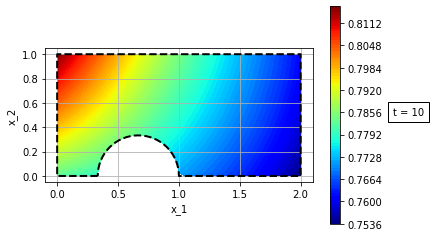

In [8]:
from torchphysics.utils.plot import _plot
fig = _plot(model=solver.model, solution_name=u, plot_variables=x, points=500,
            dic_for_other_variables={'t' : 10}, plot_type='contour_surface') # = 'quiver_2D' for vectors
fig.axes[0].set_box_aspect(1/2)

MovieWriter ffmpeg unavailable; using Pillow instead.


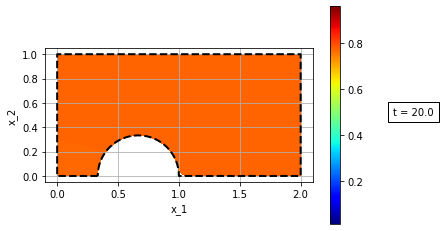

In [9]:
%load_ext autoreload
%autoreload 2
from torchphysics.utils.animation import animation
fig, ani = animation(model=solver.model, solution_name=u, plot_variable=x, domain_points=400, 
                animation_variable=t, frame_number=100, ani_type='contour_surface') # = 'quiver_2D' for vectors
fig.axes[0].set_box_aspect(1/2)
ani.save('flow.gif')